# Complex Networks Project
All countries interact through globalized trade. The value of trade between two countries depends on many aspects that are not directly highlighted in the data: common language, geographical proximity, historical links, crucial dependency...
The intention here is to start from raw data only showing global trade links and to try to recognise known structures such as international organisations, shared-language areas, similarly-developed countries etc.

### A. Merchandise Dataset

Looking into the **World Trade Organization** website, many different datasets are available. I first chose the one about annual Merchandise Values.

In [24]:
import pandas as pd
import networkx as nx
import os, re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("merchandise_values_annual_dataset.csv")

#### 1. Description

In [261]:
data.iloc[[0,-70]]

,Reporter_code,Reporter_description,Partner_code,Partner_description,Indicator_code,Indicator_description,Flow_Code,Flow_Description,Year,Unit,Value,Flag,Source_Description,Note
0,AFR,Africa,MX,Mexico,MAOCMM,Miscellaneous manufactures,X,Exports,2005,million USD,0.419133,NaN,WTO,NaN
960947,ANZ,Australia and New Zealand,ZA,South Africa,MAMTOM,Other machinery,X,Exports,2004,million USD,91.396000,NaN,WTO,NaN


In [284]:
print( len(data.Reporter_description.unique()), 
       len(data.Partner_description.unique()), 
       len(data.Indicator_description.unique()))

285 49 31


Here we see that we get about a million data rows, each indicating various aspects of the trade:
* **reporting area**: 285 possibilities including Africa or Australia+NZ.
* **trade partner**: 49 possibilities including Mexico or South Africa.
* **type of merchandise**: 31 possibilities including manufactures, machinery but also fuel, fish, chemicals...
* **flow type**: import or export. There is also Domestic export, Re-export and Retained import, but I don't understand the technical difference and prefer to eliminate these few instances (see numbers below: only 1300 data points are involved).

In [281]:
data.groupby("Flow_Description")[["Reporter_code", "Note"]].count()

,Reporter_code,Note
Flow_Description,,
Domestic exports,78,0
Exports,635097,0
Imports,323931,0
Re-exports,1163,0
Retained imports,78,0


* **year** of the trade. Period spans over 70 years, but we can see below that the number of transactions is relevant only between 2001 and 2017. We may take only year 2017 as the most recent full annual data.


Dataset spans from 1948 to 2018.


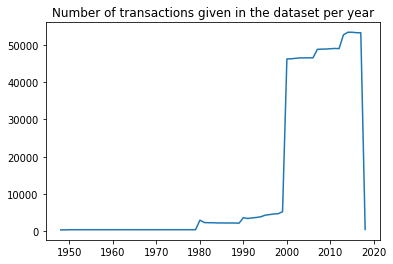

In [310]:
print("Dataset spans from {} to {}.".format(min(data.Year), max(data.Year)))
plt.plot((data.groupby("Year")["Year"].count()))
plt.title("Number of transactions given in the dataset per year")
plt.show()

data17 = data[data.Year == 2017]

* **value** in millions of US\$. We remove 0\$ transactions that probably refer to missing data.

As we saw above, the number of distinct reporters is not the same than the number of partners. Indeed, when we look closer, some entities (like countries) may report a trade that took place with an abstract entity (like  World) that does not report in itself. In fact, only 36 entities are both reporters and partners, and they are indifferently countries, international organizations, development groups, continents...

In [313]:
reporters = set(data.Reporter_description)
partners = set(data.Partner_description)

In [355]:
print(len(partners & reporters))
(partners & reporters)

36


{'Africa',
 'Andean Community (ANDEAN)',
 'Asia',
 'Association of Southeast Asian Nations (ASEAN)',
 'Australia and New Zealand',
 'Brazil',
 'Central African Economic and Monetary Community (CAEMC)',
 'China',
 'Common Market for Eastern and Southern Africa (COMESA)',
 'Commonwealth of Independent States (CIS), including associate and former member States',
 'Economic Community of Central African States (ECCAS)',
 'Economic Community of West African States (ECOWAS)',
 'Europe',
 'European Union (28)',
 'Four East Asian traders',
 'India',
 'Japan',
 'Least-developed countries, current membership',
 'Mexico',
 'Middle East',
 'Non-EU Western Europe',
 'Non-EU south-eastern Europe',
 'North America',
 'North American Free Trade Agreement (NAFTA)',
 'Other Africa',
 'Other Asia',
 'Other CIS (CIS11)',
 'Other Europe',
 'Pacific Alliance',
 'Russian Federation',
 'South Africa',
 'South and Central America and the Caribbean',
 'Southern African Development Community (SADC)',
 'Southern C

In [350]:
print(len(partners - reporters), "partners do not report:")
print("; ".join(list(partners - reporters)[6:] + ["..."]))

13 partners do not report:
World; Extra NAFTA Trade; Extra Andean Community Trade; Extra ECCAS Trade; Extra MERCOSUR Trade; Extra ECOWAS Trade; Extra SADC Trade; ...


In [352]:
print(len(reporters - partners), "reporters are not mentioned as partners:")
print("; ".join(list(reporters - partners)[135:145] + ["..."]))

249 reporters are not mentioned as partners:
Switzerland; Suriname; Antigua and Barbuda; Moldova, Republic of; France; Uruguay; G20 Members; Guinea; Bhutan; Spain; ...


Moreover, this aggregation style of reporting is hard to interpret even for entities that are both reporters and partners. Hereafter we see that the 28-members European Union reported only 3 partners (World, extra EU and itself), while 42 entities mentioned it as partner.

In [411]:
EU28partners = data[data.Reporter_description == "European Union (28)"]["Partner_description"].unique()
EU28reporters = data[data.Partner_description  == "European Union (28)"]["Reporter_description"].unique()
print(len(EU28partners), "partners:", ", ".join(list(EU28partners)))
print(len(EU28reporters), "reporters.")

3 partners: European Union (28), World, Extra EU Trade
42 reporters.


With all these considerations, we can see that the dataset is not really about bilateral trade, but more a description of vague origin and destination of goods. It may be hard to model into a nice directed network, but let's try.

#### 2. Modelisation
Using the `networkx` library, we create a directed graph where vertices are the 298 entities that have been seen either in Reporters or in Partners. Edges will be directed (out for exports, in for imports) and weighted by the sum of values between the two entities, regardless of the type of merchandise, for now.

In [160]:
G = nx.DiGraph()
vertices = list(partners | reporters)
G.add_nodes_from(vertices)
print(len(G.nodes))

NameError: name 'partners' is not defined

In [369]:
for i, trade in data.iterrows():
    # direction of edge 
    if trade["Flow_Code"] == "X": # export
        origin, destination = trade["Reporter_description"], trade["Partner_description"]
    elif trade["Flow_Code"] == "M": # import
        origin, destination = trade["Partner_description"], trade["Reporter_description"]
    else: 
        continue # we eliminate Domestic exports, Re-exports, Retained imports
        
    # additional weight for the edge
    value = float(trade["Value"])
    if value == 0: continue
    
    if destination in G[origin]:
        G[origin][destination]['weight'] += value
    else:
        G.add_edge(origin, destination, weight=value)
        print(origin, "exports to", destination)

Africa exports to Mexico
Africa exports to Other Africa
Africa exports to Australia and New Zealand
Africa exports to Other CIS (CIS11)
United Arab Emirates exports to World
World exports to United Arab Emirates
Africa exports to World
Africa exports to South Africa
Australia and New Zealand exports to Brazil
Australia and New Zealand exports to Mexico
Africa exports to Brazil
Africa exports to Commonwealth of Independent States (CIS), including associate and former member States
Australia and New Zealand exports to Other CIS (CIS11)
Australia and New Zealand exports to Australia and New Zealand
Africa exports to Asia
Africa exports to Middle East
Asia exports to Argentina
Argentina exports to Asia
North America exports to Argentina
Argentina exports to North America
Argentina exports to Other CIS (CIS11)
Africa exports to European Union (28)
Africa exports to United States of America
Argentina exports to Brazil
Brazil exports to Argentina
Africa exports to Non-EU Western Europe
Argent

Canada exports to Asia
Asia exports to Canada
South and Central America and the Caribbean exports to North America
Four East Asian traders exports to Bolivia, Plurinational State of
Non-EU south-eastern Europe exports to Bolivia, Plurinational State of
Bolivia, Plurinational State of exports to India
Canada exports to Other CIS (CIS11)
Other CIS (CIS11) exports to Canada
Central African Economic and Monetary Community (CAEMC) exports to Africa
Bolivia, Plurinational State of exports to Four East Asian traders
Bolivia, Plurinational State of exports to Japan
Bolivia, Plurinational State of exports to Non-EU south-eastern Europe
Brazil exports to Other Asia
Bolivia, Plurinational State of exports to Commonwealth of Independent States (CIS), including associate and former member States
Common Market for Eastern and Southern Africa (COMESA) exports to Middle East
Common Market for Eastern and Southern Africa (COMESA) exports to North America
Commonwealth of Independent States (CIS), includ

Cyprus exports to World
World exports to Cyprus
World exports to Germany
Brazil exports to Africa
World exports to Benin
World exports to Bosnia and Herzegovina
Bosnia and Herzegovina exports to World
Brazil exports to South and Central America and the Caribbean
Australia and New Zealand exports to North America
American Samoa exports to World
World exports to American Samoa
Azerbaijan exports to World
World exports to Azerbaijan
World exports to Belgium
Belgium exports to World
Asia exports to World
Democratic Republic of the Congo exports to World
South and Central America and the Caribbean exports to United States of America
Brazil exports to Commonwealth of Independent States (CIS), including associate and former member States
Common Market for Eastern and Southern Africa (COMESA) exports to United States of America
Denmark exports to World
World exports to Denmark
India exports to Ecuador
Ecuador exports to India
Ecuador exports to Brazil
Brazil exports to Ecuador
Germany exports 

Non-EU south-eastern Europe exports to Ecuador
Colombia exports to Middle East
Middle East exports to Colombia
Commonwealth of Independent States (CIS), including associate and former member States exports to Ecuador
North America exports to Colombia
Colombia exports to North America
Chile exports to China
China exports to Chile
Ecuador exports to Commonwealth of Independent States (CIS), including associate and former member States
Europe exports to Non-EU Western Europe
Other CIS (CIS11) exports to South and Central America and the Caribbean
Ecuador exports to Japan
North American Free Trade Agreement (NAFTA) exports to World
World exports to North American Free Trade Agreement (NAFTA)
Africa exports to Ecuador
Ecuador exports to Africa
North American Free Trade Agreement (NAFTA) exports to Africa
Africa exports to North American Free Trade Agreement (NAFTA)
Commonwealth of Independent States (CIS), including associate and former member States exports to China
Colombia exports to Lea

Ecuador exports to Australia and New Zealand
Colombia exports to Other Asia
Other Asia exports to Colombia
Eritrea exports to World
World exports to Eritrea
BRICS members exports to World
World exports to BRICS members
World exports to Commonwealth of Independent States (CIS), including associate and former member States
World exports to Africa, CIS and Middle East
Africa, CIS and Middle East exports to World
World exports to Economic Community of Central African States (ECCAS)
World exports to Europe
Europe exports to Australia and New Zealand
Ecuador exports to Mexico
Mexico exports to Ecuador
Greece exports to World
World exports to Greece
Central African Economic and Monetary Community (CAEMC) exports to Non-EU Western Europe
Brazil exports to Andean Community (ANDEAN)
Andean Community (ANDEAN) exports to Brazil
North American Free Trade Agreement (NAFTA) exports to Non-EU Western Europe
Non-EU Western Europe exports to North American Free Trade Agreement (NAFTA)
Other CIS (CIS11) 

Non-EU Western Europe exports to Colombia
Colombia exports to Non-EU Western Europe
Economic Community of West African States (ECOWAS) exports to Extra ECOWAS Trade
South and Central America and the Caribbean exports to Andean Community (ANDEAN)
Andean Community (ANDEAN) exports to South and Central America and the Caribbean
Southern Common Market (MERCOSUR) exports to Non-EU Western Europe
Non-EU Western Europe exports to Southern Common Market (MERCOSUR)
G20 - Developed Economies exports to World
World exports to G20 - Developed Economies
Middle East exports to Association of Southeast Asian Nations (ASEAN)
Association of Southeast Asian Nations (ASEAN) exports to Middle East
European Union (28) exports to North American Free Trade Agreement (NAFTA)
North American Free Trade Agreement (NAFTA) exports to European Union (28)
Ecuador exports to Europe
Europe exports to Ecuador
Association of Southeast Asian Nations (ASEAN) exports to Mexico
Mexico exports to Association of Southeast Asi

Association of Southeast Asian Nations (ASEAN) exports to South and Central America and the Caribbean
South and Central America and the Caribbean exports to Association of Southeast Asian Nations (ASEAN)
Honduras exports to World
Southern Common Market (MERCOSUR) exports to South Africa
South Africa exports to Southern Common Market (MERCOSUR)
North American Free Trade Agreement (NAFTA) exports to India
India exports to North American Free Trade Agreement (NAFTA)
World exports to Saint Kitts and Nevis
Saint Kitts and Nevis exports to World
Economic Community of West African States (ECOWAS) exports to Non-EU Western Europe
Economic Community of West African States (ECOWAS) exports to Other Asia
Economic Community of Central African States (ECCAS) exports to Least-developed countries, current membership
Japan exports to Asia
Economic Community of Central African States (ECCAS) exports to Middle East
Japan exports to Non-EU south-eastern Europe
North American Free Trade Agreement (NAFTA) 

Middle East exports to Russian Federation
Extra NAFTA Trade exports to Mexico
Mexico exports to Extra NAFTA Trade
Extra Pacific Alliance Trade exports to Mexico
Mexico exports to Extra Pacific Alliance Trade
Other Europe exports to Non-EU Western Europe
Middle East exports to Four East Asian traders
Pacific Alliance exports to Four East Asian traders
Four East Asian traders exports to Pacific Alliance
Pacific Alliance exports to Non-EU Western Europe
Non-EU Western Europe exports to Pacific Alliance
Kyrgyz Republic exports to World
Middle East exports to Other Africa
World exports to Nicaragua
Nicaragua exports to World
Montserrat exports to World
World exports to Montserrat
LDC oil exporters exports to World
World exports to LDC oil exporters
Middle East exports to Non-EU Western Europe
India exports to Four East Asian traders
Middle East exports to Other Asia
India exports to Other Africa
India exports to Non-EU south-eastern Europe
India exports to Other Europe
Other Africa exports 

North America exports to Other Africa
Four East Asian traders exports to Other Africa
Four East Asian traders exports to Other Asia
North America exports to Other Asia
Non-EU Western Europe exports to Other Africa
Other Asia exports to Least-developed countries, current membership
Japan exports to Peru
Peru exports to Japan
North America exports to China
Non-EU Western Europe exports to Other Asia
Non-EU south-eastern Europe exports to Commonwealth of Independent States (CIS), including associate and former member States
Peru exports to Mexico
Russian Federation exports to South Africa
Russian Federation exports to Non-EU south-eastern Europe
Other Asia exports to Other Africa
Other Asia exports to Other Asia
Non-EU Western Europe exports to Middle East
North America exports to Least-developed countries, current membership
Mexico exports to Peru
Other Asia exports to Middle East
Russian Federation exports to Non-EU Western Europe
North America exports to Europe
North America exports to

Non-EU south-eastern Europe exports to Japan
Non-EU south-eastern Europe exports to Least-developed countries, current membership
Russian Federation exports to Other CIS (CIS11)
Russian Federation exports to Commonwealth of Independent States (CIS), including associate and former member States
Non-EU south-eastern Europe exports to Middle East
Non-EU south-eastern Europe exports to European Union (28)
Non-EU Western Europe exports to South Africa
Non-EU south-eastern Europe exports to Other Africa
Non-EU south-eastern Europe exports to North America
Russian Federation exports to Four East Asian traders
Russian Federation exports to Australia and New Zealand
Russian Federation exports to China
Other Africa exports to North America
Other Africa exports to Four East Asian traders
Non-EU south-eastern Europe exports to Four East Asian traders
Non-EU south-eastern Europe exports to Other Europe
Southern African Development Community (SADC) exports to China
Southern African Development Commu

South Africa exports to Russian Federation
Other Europe exports to Europe
Other Europe exports to India
West African Economic and Monetary Union (WAEMU) exports to Non-EU Western Europe
Africa exports to Venezuela, Bolivarian Republic of
Venezuela, Bolivarian Republic of exports to Africa
Other Europe exports to Least-developed countries, current membership
Venezuela, Bolivarian Republic of exports to Australia and New Zealand
Australia and New Zealand exports to Venezuela, Bolivarian Republic of
Other Europe exports to Middle East
Brazil exports to Venezuela, Bolivarian Republic of
Asia exports to Venezuela, Bolivarian Republic of
West African Economic and Monetary Union (WAEMU) exports to South Africa
West African Economic and Monetary Union (WAEMU) exports to Other Asia
South Africa exports to Other Africa
Other CIS (CIS11) exports to Venezuela, Bolivarian Republic of
South Africa exports to Other Asia
Venezuela, Bolivarian Republic of exports to Asia
Venezuela, Bolivarian Republic 

World exports to French Southern Territories
French Southern Territories exports to World
European Union (27) exports to Extra EU Trade
Extra EU Trade exports to European Union (27)
Saint Martin exports to World
World exports to Saint Martin
WTO Member Countries exports to World
World exports to WTO Member Countries


We get about 2000 edges, such as `India exports to Asia`, `World exports to Iraq`, `Andean Community (ANDEAN) exports to Middle East`, with values ranging from 25k\$ to three hundred trillion dollars, whatever this means (from Europe to World).

In [401]:
weights = [e[2]['weight'] for e in G.edges.data()]
print(min(weights), int(max(weights)))
print([e for e in G.edges.data() if e[2]['weight'] > 300000000])

0.025992 303567440
[('Europe', 'World', {'weight': 303567440.4245577})]


In [412]:
G["World"]["France"], G["France"]

({'weight': 44164272.42309765},
 AtlasView({'World': {'weight': 40858203.24918346}}))

We can already see a big problem: most individual countries will report only their trade with the rest of the world, as we can see with the example of France above.

#### 3. Representation
Tu further the analysis, we will use `Gephi` to plot the graph nicely. First, the data has to be exported, either in simple adjacency list or in weighted edge list.

In [413]:
nx.write_adjlist(G, "merchandise_adjlist.csv", delimiter=";")
nx.write_weighted_edgelist(G, "merchandise_weighted_edgelist.csv", delimiter=";")

[('Europe', 'World', {'weight': 303567440.4245577})]

We obtain a messy graph where average degree is under 7, diameter is 4 and density is 2%. Now an idea is to apply a community detection algorithm: the simplest is to take what Gephi offers, and it gives a nice coloring as well. ![Full graph of merchandise trade](merchandise.png)

The network is visibly made of two parts: a star (purple) with many nodes connected to a single central node, and a densely connected part where communities are hard to observe. When we look closer and plot the labels, we see that the star is centered around World, and most individual countries are connected to it but to nothing else.

Eliminating nodes with topological degree under 3, we keep 53 nodes that have average degree of 28 which leads to a very dense graph (55%). Now an other filter can be applied to remove thin edges.

![Simplified graph of merchandise trade](merchandise_reduced.png)

### B. Service Trade Dataset

Now we search for cleaner bilateral trade data. The WTO provides an interesting exampe with [bilateral trade for services](https://www.wto.org/english/res_e/statis_e/trade_datasets_e.htm), referenced over the years (from 1988 to 2017). Each year, a given country is associated to its five main import and export partners.
This dataset will allow us to obtain a quite sparse graph, with less than $10\times n$ edges for $n\approx 200$ nodes.

#### 1. Graph creation
Data is given in one file per country, and in each file we extract information about main import partners, main export partners, and the corresponding amounts. Some irrelevant data is removed (eg exports to the world, unspecified partners, total import of a country...)

In [310]:
files = os.listdir("trade/")
# remove reported countries that are not relevant
wrong_countries = [' World', 'Special Categories', 'Unspecified', 'Bunkers']

def createGraph(year, verbose=False):
    year = str(year)
    H = nx.DiGraph()
    if verbose: print(len(H.nodes))
    
    for f in sorted(files):
        t = pd.read_csv("trade/" + f, encoding = "ISO-8859-1")
        reporter = t["Reporter"].iloc[0]
        if type(reporter) != type("a"): continue # global reports
        if reporter in wrong_countries: continue
        if reporter not in H.nodes:
            H.add_node(reporter)

        trades = (t[
            (t["Partner"] != "...") &    # bilateral trade only
            ~np.isnan(t[year]) &         # selected year only
            [a.find("Trade") >= 0 for a in t["Indicator"]]  # trade value (not %)
        ][["Partner", "Indicator Type", year]])
        
        for _, i in trades.iterrows():
            partner = i["Partner"]
            if partner in wrong_countries: continue
            if partner not in H.nodes:
                H.add_node(partner)

            # direction of edge 
            if i["Indicator Type"] == "Export":
                origin, destination = reporter, partner
            elif i["Indicator Type"] == "Import":
                origin, destination = partner, reporter
            else: print("Error: unknown indicator ", i["Indicator Type"]); continue

            # additional weight for the edge
            value = float(i[year])
            if value == 0: continue
            if destination in H[origin]:
                H[origin][destination]['weight'] += value
            else:
                H.add_edge(origin, destination, weight=value)
                if verbose: print(origin, "exports to", destination)
    if verbose: print(len(H.edges))
    return H.copy()

def exportGraph(H, title):
    nx.write_adjlist(H, "services_adjlist"+title+".csv", delimiter=";")
    nx.write_weighted_edgelist(H, "services_weighted_edgelist"+title+".csv", delimiter=";")

In [590]:
H = {}
for y in range(1988,2018):
    print("Year ", y, end=": ")
    H[y] = createGraph(y)
    print(len(H[y].edges), " trades")

print(set(sum([list(H[y].nodes) for y in H], [])))

{'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguila',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belgium-Luxembourg',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Cook Islands',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'Czechoslovakia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt, Arab Rep.',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',

We use `createGraph` to obtain 30 directed graphs with 230 different nodes, many of which appear in many or all years. Every year, there are about a thousand referenced partnerships. Using `exportGraph`, we can send the data to Gephi and plot a nice representation of the graph with analysis. Here is an example for year 2017.

![Graph of service trade](services_adjlist_.png)

In this image, node size is given by degree, edge size by their weight, and color by community belonging. A community detection algoritm was used to optimize modularity and output 8 classes. The communities match more or less the geography: Americas in orange, South and East Asia in blue, Europe in purple, Africa in pink... but the algorithm is randomized and such a match was not obvious in all attemps I made. The 2D display is given by Yifan Hu algorithm proposed in Gephi.

#### 2. Analysis of a year
More numerically, we may be interested in seeing the importance of each node in international trade for a given year. Interesting values include:
* _degree_, _in_ or _out_, to show what contries are partnering with most other countries
* _page rank_ that shows what countries are more often "visited" by traded items
* _betweenness_ to compute how often a given country appears on shortest paths
* _closeness_ that shows what countries are near every other one in the trade graph

`rankAnalysis` shows the top 10 countries for each of these values, as well as the distribution of this value among all countries (a log-log-scale is used to show a broader range of values, and to highlight the curve in top-ranking nodes). Note that a pseudorandom color is given to countries with `countryColor` so that histograms are easier to compare.

In [651]:
def countryColor(name):
    cmap = matplotlib.cm.get_cmap("tab10").colors
    return cmap[(11*ord(name[0]) + 23*ord(name[-1])) % len(cmap)]

def getRanking(f, H):#, weight=None):
    scores = f(H)#, weight=weight)
    ranking = sorted([(float(scores[i]), i) for i in scores], reverse=True)
    np_ranking = np.array(ranking, dtype=type((0.1, "a")))
    return np_ranking

def centralityPlot(fig, i, ranking, name):
    top15 = ranking[:10]
    rows, columns = 5, 2

    f = (fig.add_subplot(rows, columns, 2*i-1))
    labels = [top15[i][1] for i in range(len(top15))]
    values = [top15[i][0] for i in range(len(top15))]
    colors = [countryColor(l) for l in labels]
    y_pos = np.arange(len(labels),0,-1)
    f.barh(y_pos, values, align='center', alpha=1, color = colors)
    plt.yticks(y_pos, labels)
    plt.title(name + " leaders")
    
    f = fig.add_subplot(rows, columns, 2*i)
    plt.plot((ranking[:,1]), (ranking[:,0]))
    plt.loglog() # yscale("log")
    plt.title(name + " distribution")

functions = [
        (nx.in_degree_centrality, "In-degree"),
        (nx.out_degree_centrality, "Out-degree"),
        (nx.pagerank, "Weighted PageRank"),
        (nx.betweenness_centrality, "Betweenness"),
        (nx.closeness_centrality, "Closeness"),   
    ]
    
def rankAnalysis(H, title=None, weight=None):
    fig = plt.figure(figsize=(9, 20))
    
    for i in range(len(functions)):
        centralityPlot(fig, i+1, getRanking(functions[i][0], H), functions[i][1])

    plt.show()
    
    return #nprl



Year 2017 is the most recent we have. The different values computed show interesting trends. First of all, in-degree and out-degree give distinct rankings, even if the countries in each list are quite similar; in particular, countries famous for exportation including Japan and China rank much better in out-degree, as expected. 

For page rank, we see that the USA dominate, which is not as clear with other indicators. We can also see that European Union appears in fourth position: only a few countries report the Union as a trade partner, but they are usually well-connected countries with intense trade, and page rank gives therefore a lot of importance to this entity.

For betweenness, we see that the 3 usual leaders (China, USA, Germany) really stand out, meaning that they tend to link countries that do not trade directly. For closeness, all leading nodes have a comparable value, and we see on the distribution that only very isolated nodes have a much lower value of closeness: it drops around the 100th.

Hereafter are the plots for 2017 as well as 2000 and 1993. Though many things changed over time, countries appearing often among the leaders remain the same.

In [643]:
print("Countries reporting European Union as one partner are",
      ", ".join(
        set(list(H[2017]["European Union"]) +
        [i for i in H[2017] if "European Union" in H[2017][i]])) +".")

Countries reporting European Union as one partner are United States, Switzerland, China, Russian Federation, Turkey.


Rank analysis for year 2017


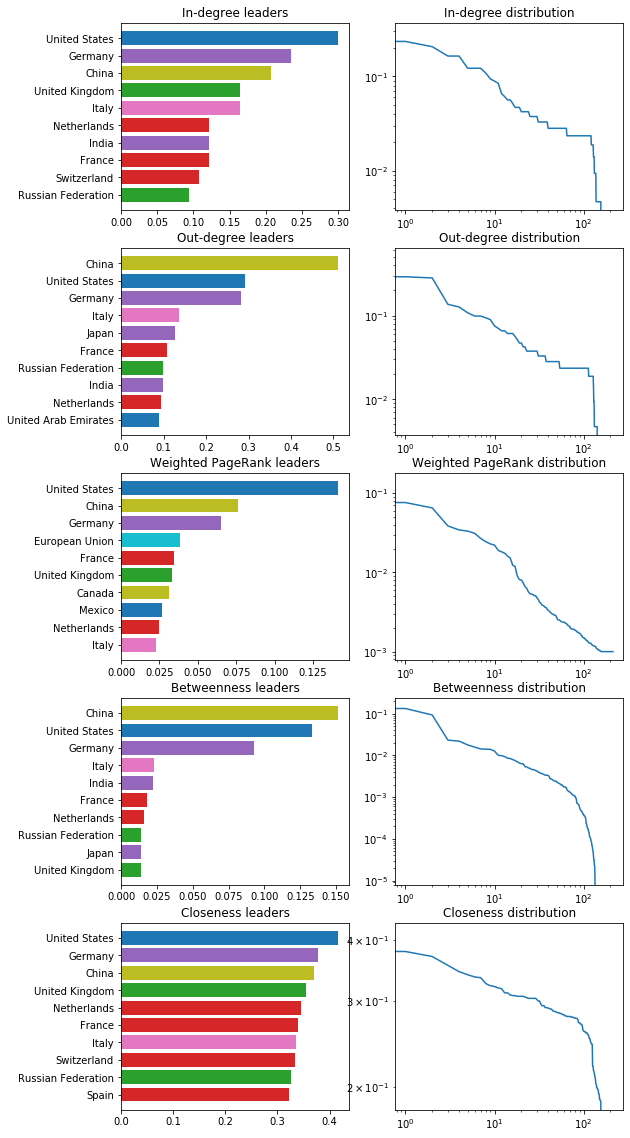

Rank analysis for year 2000


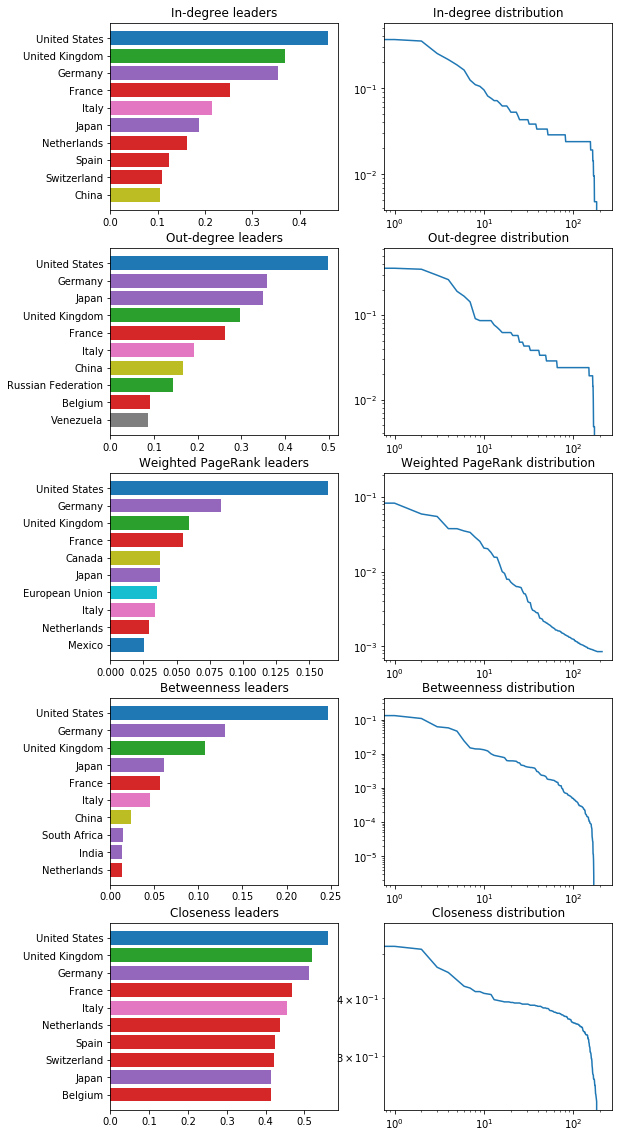

Rank analysis for year 1993


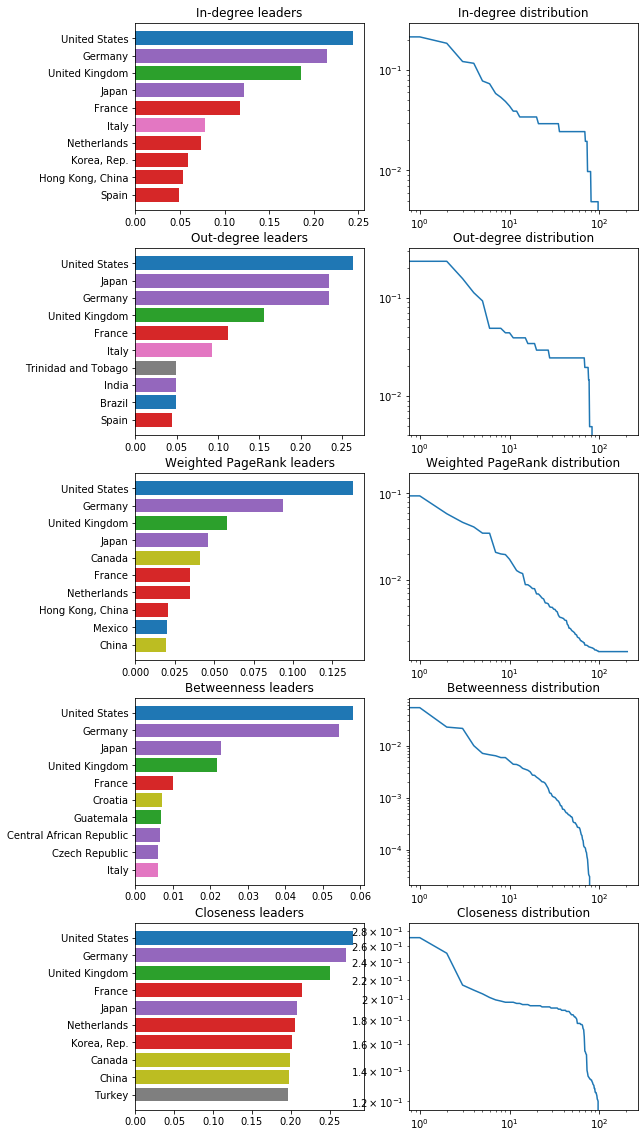

In [623]:
for y in [2017, 2000, 1993]:
    print("Rank analysis for year", y)
    rankAnalysis(H[y])

Now if we look closer into those leaders, we may be able to see an evolution over the years. Countries are said to have grown economically at different moments in History, and we may be able to see that.

#### 3. Evolution over time
Which countries should be studied ? Let's select those that appeared in any top 4 at any point in our 30-years long History. The function `topCountries` suggest we analyse Japan, Canada, Germany, United States, Romania, France, European Union, Italy, Finland, Thailand, India, China, United Kingdom.

In [672]:
def topCountries(n):
    top = [{} for i in range(len(functions))]
    for y in H:
        for i in range(len(functions)):
            top5 = getRanking(functions[i][0], H[y])[:n]
            for j in range(len(top5)):
                country = top5[j][1]
                if country not in top[i]:
                    top[i][country] = {}
                top[i][country][y] = j+1
    return top
c = topCountries(4)

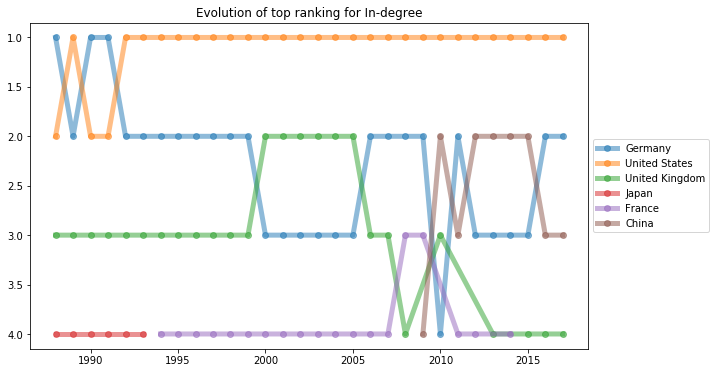

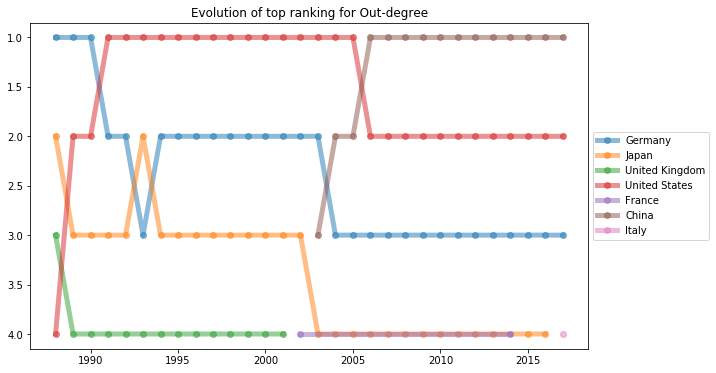

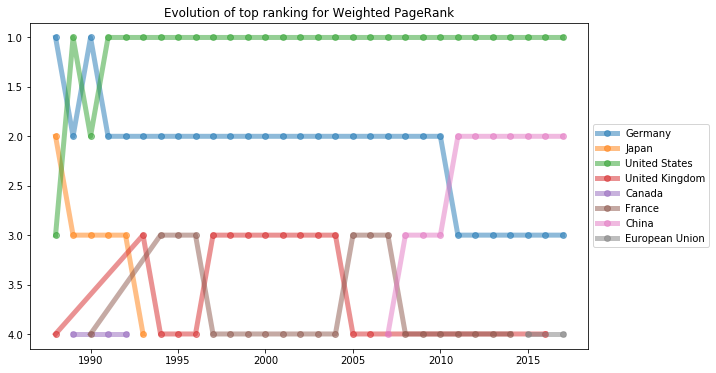

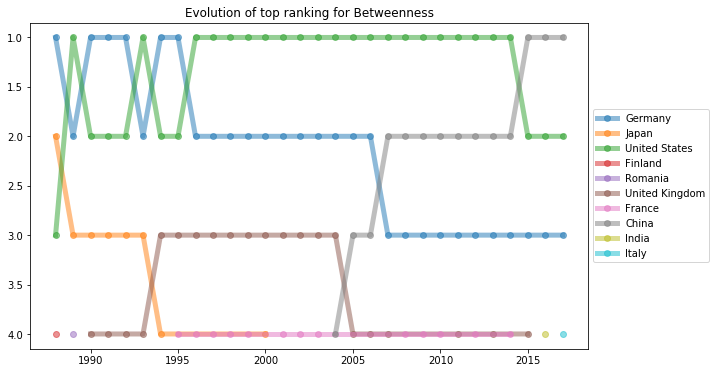

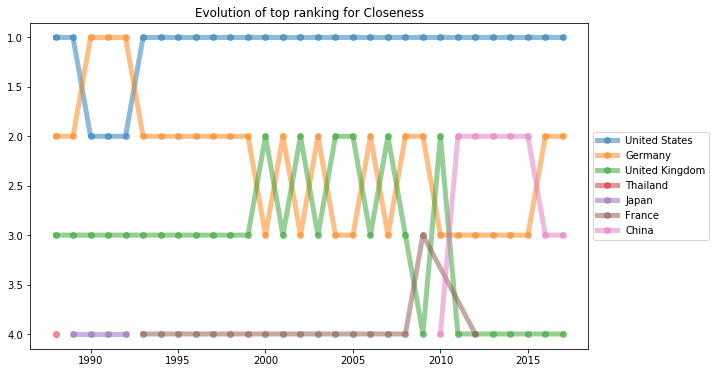

In [712]:
for i in range(len(c)):
    plt.figure(figsize=(10,6))
    for country in c[i]:
        years = [y for y in c[i][country]]
        ranks = [c[i][country][y] for y in c[i][country]] #c=countryColor(country)
        plt.plot(years, ranks, marker="o", label=country, alpha=.5, linewidth=5)
    plt.gca().invert_yaxis()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Evolution of top ranking for "+ functions[i][1])
    plt.show()

To be more readable, it would be interesting to smooth the curves over several years, or to aggregate all indicators into one (maybe taking the average rank would be interesting enough). However, we can still see interesting things: China appears at first in betweenness and out-degree in 2003, before rising in all other rankings; the UK is dropping in all indicators, while USA, Germany and Japan stay most of the time in the top 3 values.


### C. Further work

This dataset is interesting even though it does not contain all the information, in particular trade with minor partners. There are some inconsistencies, as in the fact that simmetrical reports can be different (for France's export to Belgium, the value reported by France is slightly different from the value reported by Belgium). Therefore, we could be interesting in a graph in which weight is removed, and edges exist only to show that a country _target_ is very important economically for a country _source_, regardless if the importance is for import or for export. I expoect that such a graph would be very different: every node would point toward 10 nodes at most, but could be pointed at by dozens.

Community detection was quite a deception as I was not able to capture more than pure geographical things. We could dig deeper into that and try to obtain political insights. For instance, I expected that early data ($\approx$1990) would show the so-called bipolar world, with a strong cut between Russia and the USA. My explorations in that direction did not yield much, but it may be because the data for first years is quite poor.

It would be interesting if dynamic communities can be analysed, with results that may be able to observe long-scale political events, such as the creation and growth of the European Union, the breakdown of USSR, the growing reliance of Africa on China instead of Weastern Europe...

Finally, we could reproduce other works that tried to match international trade on gravity or radiation models, by using country GDP and coordinates for mass and position, for instance.